In [1]:
import json
import warnings

import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import scipy.stats as st

from tqdm import tqdm
from os import listdir
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, ParameterSampler
from sklearn.metrics import accuracy_score, hamming_loss

warnings.filterwarnings("ignore")
%matplotlib inline

def process(df):
    df["len"]=df.index.to_series().apply(lambda x: len(x.split("/")[-1]))
    df["sub"]=df.index.to_series().apply(lambda x: x.count("_"))
    df["dash"]=df.index.to_series().apply(lambda x: x.count("-"))
    df["dot"]=df.index.to_series().apply(lambda x: x.count("."))
    df["space"]=df.index.to_series().apply(lambda x: x.count(" "))
    df["jpg"]=df.index.to_series().apply(lambda x: int(x.endswith(".jpg")))
    df["cap"]=df.index.to_series().apply(lambda x: sum(1 for c in x if c.isupper()))
    df["num"]=df.index.to_series().apply(lambda x: sum(1 for c in x if c.isdigit()))
    #df["eq"]=df.index.to_series().apply(lambda x: x.count("&"))
    #df["amp"]=df.index.to_series().apply(lambda x: x.count("="))
    #df["img"]=df.index.to_series().apply(lambda x: int("IMG" in x))
    
    return df

path = "./output/"
subm = "./submit/"

In [ ]:
#MAJORITY VOTING

l = [c for c in sorted(listdir(path)) if c.endswith("json")]

ans = dict()
for f in tqdm(l):
    with open(path+f) as file:
        f = json.load(file)
    for c in f:
        if c['image_id'] in ans:
            ans[c['image_id']].append(c['disease_class'])
        else:
            ans[c['image_id']] = [c['disease_class']]
        #break
    #break

sub = []
for x in list(ans):
    y=list(Counter(ans[x]))[0]
    sub.append({
                            "image_id": x,
                            "disease_class":int(y) 
                        })

    
with open(subm+"submit_majority.json", 'w') as outfile:
    json.dump(sub, outfile)

In [80]:
#AVERAGE PROBABILITY

df = pd.DataFrame()

l = [c for c in sorted(listdir(path)) if c.endswith("csv") and "test" in c]
for f in tqdm(l):
    dt = pd.read_csv(path+f, index_col="id")
    for c in dt.columns:
        if c in df.columns:
            df[c] += dt[c]
        else:
            df[c] = dt[c]
    #break
for c in df.columns:
    df[c] /= len(l)
    
ans = dict(df.idxmax(axis=1))

sub = []
for x in list(ans):
    y=ans[x]
    sub.append({
                            "image_id": x,
                            "disease_class":int(y) 
                        })

with open(subm+"submit_avg.json", 'w') as outfile:
    json.dump(sub, outfile)

100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


In [129]:
#STACKING - TEST

df = pd.DataFrame()

dt = pd.read_csv("./input/meta_testA.csv", index_col="name")
for c in ["w","h","r"]:
    df[c] = dt[c]
df["d"] = df["w"]-df["h"]    
df["s"] = df["w"]+df["h"]
df["label"] = [-1]*len(df)

df.index.names = ['id']

dc = pd.read_csv("./input/more_feat_test_.csv", index_col = "images")
dc.index.names = ['id']
dc.index = dc.index.to_series().apply(lambda x: x[13:])

for c in dc.columns:
    df[c] = dc[c]

df = process(df)

for suf in ["_n_"]:
    dff = df.copy()
    cols = []
    l = [c for c in sorted(listdir(path)) if c.endswith("csv") and "test" in c and suf in c]
    for f in tqdm(l):
        dt = pd.read_csv(path+f, index_col="id")
        for c in dt.columns:
            cc = f.split(".")[0][5:-2]+"_"+str(c)
            #print(cc)
            if cc in dff.columns:
                dff[cc] += dt[c]
            else:
                dff[cc] = dt[c]
            cols.append(cc)
            
    for c in set(cols):
        dff[c] /= 5

    dff.to_csv(f"./input/test_prob{suf}.csv")


100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


In [ ]:
#STACKING - VALID

df = pd.read_csv("./input/meta_validation.csv", index_col="name")
df.index = ["valid/"+x for x in df.index]

df["d"] = df["w"]-df["h"]    
df["s"] = df["w"]+df["h"]

df.index.names = ['id']
    
da = pd.read_csv("./input/more_feat_valid_.csv", index_col = "images")
da.index.names = ['id']
da.index = da.index.to_series().apply(lambda x: x[8:])

for c in da.columns:
    df[c] = da[c]
df = process(df)

for suf in ["_n_"]:
    dff = df.copy()
    l = [c for c in sorted(listdir(path)) if c.endswith("csv") and "valid" in c and suf in c]
    for f in tqdm(l):
        dt = pd.read_csv(path+f, index_col="id")
        dq = pd.read_csv("./input/"+f[-5:-4]+"_idx.csv")
        dt.index = dq.path
        dt = dt[dt.index.str.startswith("valid")]
        
        for c in dt.columns:
            cc = f.split(".")[0][6:-2]+"_"+str(c)
            if cc not in dff.columns:
                dff[cc] = [0]*len(dff)
            dff.loc[dt.index, cc] = dt[c]
        #break
    dff.to_csv(f"./input/valid_prob{suf}.csv")

In [ ]:
dff

In [ ]:
#STACKING - TRAIN

df = pd.read_csv("./input/meta_train.csv", index_col="name")
df.index = ["train/"+x for x in df.index]

df["d"] = df["w"]-df["h"]    
df["s"] = df["w"]+df["h"]

df.index.names = ['id']
    
da = pd.read_csv("./input/more_feat_train_.csv", index_col = "images")
da.index.names = ['id']
da.index = da.index.to_series().apply(lambda x: x[8:])

for c in da.columns:
    df[c] = da[c]
df = process(df)

for suf in ["_n_"]:
    dff = df.copy()
    l = [c for c in sorted(listdir(path)) if c.endswith("csv") and "valid" in c and suf in c]
    for f in tqdm(l):
        dt = pd.read_csv(path+f, index_col="id")
        dq = pd.read_csv("./input/"+f[-5:-4]+"_idx.csv")
        dt.index = dq.path
        dt = dt[dt.index.str.startswith("train")]
        
        for c in dt.columns:
            cc = f.split(".")[0][6:-2]+"_"+str(c)
            if cc not in dff.columns:
                dff[cc] = [0]*len(dff)
            dff.loc[dt.index,cc] = dt[c]

    dff.to_csv(f"./input/train_valid_prob{suf}.csv")

In [ ]:
#STACKING - TRAIN+VALID

df = pd.read_csv("./input/meta_train.csv", index_col="name")
df.index = ["train/"+x for x in df.index]
dt = pd.read_csv("./input/meta_validation.csv", index_col="name")
dt.index = ["valid/"+x for x in dt.index]
df = df.append(dt)

df["d"] = df["w"]-df["h"]    
df["s"] = df["w"]+df["h"]

df.index.names = ['id']
    
da = pd.read_csv("./input/more_feat_train_.csv", index_col = "images")
da.index.names = ['id']
da.index = da.index.to_series().apply(lambda x: x[8:])

db = pd.read_csv("./input/more_feat_valid_.csv", index_col = "images")
db.index.names = ['id']
db.index = db.index.to_series().apply(lambda x: x[8:])

da = da.append(db)

for c in da.columns:
    df[c] = da[c]
df = process(df)

for suf in ["_n_"]:
    dff = df.copy()
    l = [c for c in sorted(listdir(path)) if c.endswith("csv") and "valid" in c and suf in c]
    for f in tqdm(l):
        dt = pd.read_csv(path+f, index_col="id")
        dq = pd.read_csv("./input/"+f[-5:-4]+"_idx.csv")
        dt.index = dq.path
        #print(f[-5:])
        for c in dt.columns:
            cc = f.split(".")[0][6:-2]+"_"+str(c)
            if cc not in dff.columns:
                dff[cc] = [0]*len(dff)
            dff.loc[dt.index,cc] = dt[c]
        #break
    dff.to_csv(f"./input/train_test_prob{suf}.csv")

In [146]:
#LGBM

suf = "_n_"
test = "valid"
df = pd.read_csv(f"./input/train_{test}_prob{suf}.csv", index_col = "id")
dt = pd.read_csv(f"./input/{test}_prob{suf}.csv", index_col = "id")
dtt = pd.read_csv(f"./input/test_prob{suf}.csv", index_col = "id")

# ans = np.load("match_dict_all.npy")
# ans = ans.item()

# keep = set()
# remo = set()
# for x in ans:
#     if not x.startswith("./input/test") and not ans[x].startswith("./input/test"):
#         remo.add(x[8:])
#print(len(remo))
#print(len(df))
# df = df[~df.index.isin(remo)]
#print(len(df))
#print(len(dt))
# dt = dt[~dt.index.isin(remo)]
#print(len(dt))

num = {"len","sub","dash","dot","space","jpg","cap","num"}

color = {'average_blue',
         'average_green',
         'average_pixel_width',
         'average_red',
         'blurrness_score',
         'colorfulness',
         'max_b',
         'max_g',
         'max_r',
         'mean_b',
         'mean_g',
         'mean_r',
         'med_b',
         'med_g',
         'med_r',
         'min_b',
         'min_g',
         'min_r',
         'rms_b',
         'rms_g',
         'rms_r',
         'skew_b',
         'skew_g',
         'skew_r',
         'var_b',
         'var_g',
         'var_r'}

ad = set()
for b in ["colorfulness","blurrness_score"]:
    for c in num:
        df[b+"*"+c] = df[b]*df[c]
        dt[b+"*"+c] = dt[b]*dt[c]
        dtt[b+"*"+c] = dtt[b]*dtt[c]
        ad.add(b+"*"+c)
        
excl = {"label","date"}# +color  #,"min_g","min_r","min_b"} "d","h","r","s","w"
cols = sorted(list((set(df.columns)|ad)-excl-num))
# for c in excl+num:
#     cols.remove(c)
#cols = [c for c in cols if "_n_" in c]
print(len(cols))

rounds = 10000
early_stop_rounds = 100

param_grid = {  
            'max_depth': [1,2],
            'learning_rate': np.linspace(0.2, 0.5, 7),
            'feature_fraction': np.linspace(0.05, 0.2, 7),
            'lambda_l1': np.linspace(1, 10, 19),
            'lambda_l2': st.randint(100, 200)
         }

param_list = list(ParameterSampler(param_grid, n_iter=100))
rounded_list = [dict((k, round(v, 6)) for (k, v) in d.items())
                for d in param_list]

accuracy_ = []
score_ = []
res_ = []

params = {'feature_fraction': 0.15, 
          'lambda_l1': 3.5, 
          'lambda_l2': 160, 
          'learning_rate': 0.35, 
          'max_depth': 2,
          'boosting_type': 'gbrt', 
          'num_class': 61, 
          'objective': 'multiclass', 
          'metric': 'multi_error'}
if True:

# for i,params in enumerate(rounded_list):
#     params['boosting_type'] = 'gbrt'
#     params['num_class'] = 61
#     params['objective'] = 'multiclass'
#     params['metric'] = 'multi_error'
    
    print(params)
    accuracy = []
    score = []
    res = []
    tst = []
    
    X_test = dt[cols] #valid
    X_tst = dtt[cols] #test
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)

    fold = -1
    for train_index, valid_index in skf.split(df.index, df.label):
        fold+=1

        X_train, X_valid = df.loc[df.index[train_index], cols], df.loc[df.index[valid_index], cols]
        y_train, y_valid = df.loc[df.index[train_index],:].label, df.loc[df.index[valid_index],:].label

#         X_train, X_valid = df.loc[df.index[train_index], cols], dt.loc[:, cols]
#         y_train, y_valid = df.loc[df.index[train_index],:].label, dt.label

        lgtrain = lgb.Dataset(X_train, y_train, feature_name=cols)    
        lgvalid = lgb.Dataset(X_valid, y_valid, feature_name=cols)    

        model = lgb.train(params,
                            lgtrain,
                            num_boost_round=rounds,
                            valid_sets=[lgtrain, lgvalid],
                            valid_names=['train','valid'],
                            #feval=hamming,
                            early_stopping_rounds=early_stop_rounds,
                            verbose_eval=50)

        score.append(model.best_score["valid"]['multi_error'])
        model.save_model(f"./input/lgb/model_{test}{suf}{fold}.txt", num_iteration=model.best_iteration)
        pred = model.predict(X_tst)
        tst.append(pred)
        pred = model.predict(X_test)
        res.append(pred)
        np.save(f"./input/lgb/pred_{test}{suf}{fold}.npy", pred)

        if test == "valid":
            y_true = dt.label
            y_pred = np.argmax(pred, axis=1)
            accuracy.append(accuracy_score(y_true, y_pred))
            #print(accuracy_score(y_true, y_pred))
        #break
        
    print(np.mean(score), score)
    print(np.mean(accuracy), accuracy)

    accuracy_.append(accuracy)
    
    if test == "valid":
        score_.append(score)

        ans = []

        pred = np.min(np.array(res), axis=0)
        y_pred = np.argmax(pred, axis=1)
        ans.append(y_pred)
        a = accuracy_score(y_true, y_pred)
        print("min", a)

        pred = np.median(np.array(res), axis=0)
        y_pred = np.argmax(pred, axis=1)
        ans.append(y_pred)
        b = accuracy_score(y_true, y_pred)
        print("med", b)

        pred = np.max(np.array(res), axis=0)
        y_pred = np.argmax(pred, axis=1)
        ans.append(y_pred)
        c = accuracy_score(y_true, y_pred)
        print("max", c)

        ans = np.array(ans)
        y_pred = []
        for i in range(len(y_true)):
            x = Counter(ans[:,i]).most_common()[0][0]
            y_pred.append(x)

        d = accuracy_score(y_true, y_pred)
        print("agg", d)

        y_pred = []
        ans = np.argmax(res, axis=2)
        for i in range(len(y_true)):
            x = Counter(ans[:,i]).most_common()[0][0]
            y_pred.append(x)

        e = accuracy_score(y_true, y_pred)
        print("cnt",e,"\n")
        res_.append([a,b,c,d,e])

    y_pred = []
    ans = np.argmax(tst, axis=2)
    for i in range(len(tst[0])):
        x = Counter(ans[:,i]).most_common()[0][0]
        y_pred.append(x)
    


414
{'feature_fraction': 0.15, 'lambda_l1': 3.5, 'lambda_l2': 160, 'learning_rate': 0.35, 'max_depth': 2, 'boosting_type': 'gbrt', 'num_class': 61, 'objective': 'multiclass', 'metric': 'multi_error'}
Training until validation scores don't improve for 100 rounds.
[50]	train's multi_error: 0.0893167	valid's multi_error: 0.113972
[100]	train's multi_error: 0.073063	valid's multi_error: 0.111303
[150]	train's multi_error: 0.0611488	valid's multi_error: 0.113187
[200]	train's multi_error: 0.050142	valid's multi_error: 0.11303
Early stopping, best iteration is:
[114]	train's multi_error: 0.0695913	valid's multi_error: 0.110204
Training until validation scores don't improve for 100 rounds.
[50]	train's multi_error: 0.0906044	valid's multi_error: 0.114241
[100]	train's multi_error: 0.0735717	valid's multi_error: 0.109992
[150]	train's multi_error: 0.0607972	valid's multi_error: 0.111566
[200]	train's multi_error: 0.0512952	valid's multi_error: 0.112667
Early stopping, best iteration is:
[100]	

In [139]:
#[c for c in cols if "_n_" not in c] 

In [144]:
# y_pred = []
# ans = np.argmax(tst, axis=2)
# for i in range(len(tst[0])):
#     x = Counter(ans[:,i]).most_common()[0][0]
#     y_pred.append(x)
    
# pred = np.mean(np.array(tst), axis=0)
# y_pred = np.argmax(pred, axis=1)

sub = []
for x,y in zip(dtt.index, y_pred):
    sub.append({
                            "image_id": x,
                            "disease_class":int(y) 
                        })

with open("./submit/submit_lgb.json", 'w') as outfile:
    json.dump(sub, outfile)

In [145]:
with open("./submit/submit_lgb.json", 'r') as outfile:
    sub = json.load(outfile)

ids = []
label = []
for x in sub:
    #print(x)
    ids.append(x["image_id"])
    label.append(x["disease_class"])
    #break
    
ds = pd.DataFrame({"id":ids,"label":label})
ds.sort_values(by="id", inplace=True)

ds.label.value_counts(), len(ds)

# 59    366
#  25    261
#  26    256
#  33    206
#  58    191
#  0     172
#  41    171
#  49    168
#  30    145
#  43    143
#  28    122
#  16    116
#  55    111
#  29    110

(59    364
 25    276
 26    241
 33    205
 58    191
 0     174
 41    171
 49    164
 43    146
 30    145
 28    122
 16    116
 29    110
 55    110
 23     91
 40     86
 6      85
 56     81
 15     80
 20     72
 12     69
 19     67
 37     67
 21     63
 35     63
 54     62
 3      60
 47     60
 9      54
 32     53
 24     52
 13     50
 18     50
 50     48
 51     46
 31     42
 17     42
 48     39
 34     38
 46     37
 42     37
 60     36
 27     36
 57     35
 38     34
 36     33
 10     30
 1      29
 39     24
 11     22
 14     22
 4      20
 2      18
 7      16
 8      11
 22      7
 5       6
 52      5
 53      1
 Name: label, dtype: int64, 4514)

In [142]:
#with open("./input/ai_challenger_pdr2018_validation_annotations_20181021.json", 'r') as outfile:
#with open("./input/ai_challenger_pdr2018_train_annotations_20181021.json", 'r') as outfile:
with open("./submit/submit_majority.json", 'r') as outfile:
    sub = json.load(outfile)

ids = []
label = []
for x in sub:
    ids.append(x["image_id"])
    label.append(x["disease_class"])
    
dn = pd.DataFrame({"id":ids,"label":label})
dn.sort_values(by="id", inplace=True)

dn.label.value_counts()

59    352
25    297
26    220
33    207
58    204
41    174
0     166
49    165
30    145
43    140
28    119
55    119
16    116
29    114
23     88
6      85
40     85
20     77
15     76
37     70
19     67
56     67
35     66
12     64
47     63
3      60
21     58
32     57
13     55
9      54
54     54
24     52
18     50
57     49
51     49
50     45
42     43
17     42
27     39
48     38
60     37
31     37
34     35
38     34
11     33
10     30
36     30
1      29
46     28
39     25
4      25
2      20
7      16
14     15
8      11
22     10
52      4
53      2
5       2
Name: label, dtype: int64

In [ ]:
best
42 {'feature_fraction': 0.15, 'lambda_l1': 3.5, 'lambda_l2': 160, 'learning_rate': 0.35, 'max_depth': 2, 'boosting_type': 'gbrt', 'num_class': 61, 'objective': 'multiclass', 'metric': 'multi_error'}
0.11088474273576762 [0.11020408163265306, 0.1099921321793863, 0.11167192429022083, 0.1117080107441934, 0.11084756483238457]
0.8826431718061674 [0.8825991189427312, 0.8861233480176212, 0.8834801762114537, 0.8828193832599119, 0.878193832599119]
min 0.8852422907488987
med 0.8872246696035242
max 0.8870044052863436
agg 0.8861233480176212
cnt 0.8872246696035242

{'feature_fraction': 0.2, 'lambda_l1': 3.6, 'lambda_l2': 246, 'learning_rate': 0.9, 'max_depth': 1, 'boosting_type': 'gbrt', 'num_class': 61, 'objective': 'multiclass', 'metric': 'multi_error'}

0.11113293640185004 [0.11224489795918367, 0.11156569630212432, 0.11246056782334385, 0.11107599936798862, 0.10831752055660974]
0.880704845814978 [0.8762114537444934, 0.8803964757709251, 0.8786343612334802, 0.8825991189427312, 0.8856828193832599]
min 0.8859030837004406
med 0.8852422907488987
max 0.8854625550660793
agg 0.8861233480176212
cnt 0.8848017621145374 

38 {'feature_fraction': 0.1, 'lambda_l1': 6.0, 'lambda_l2': 178, 'learning_rate': 0.3, 'max_depth': 2, 'boosting_type': 'gbrt', 'num_class': 61, 'objective': 'multiclass', 'metric': 'multi_error'}
0.10987580307047898 [0.10863422291993721, 0.11030684500393391, 0.10993690851735016, 0.11028598514773266, 0.11021505376344086]
0.8832158590308369 [0.8823788546255507, 0.8832599118942731, 0.8819383259911894, 0.8852422907488987, 0.8832599118942731]
min 0.8845814977973568
med 0.8870044052863436
max 0.8845814977973568
agg 0.8845814977973568
cnt 0.8865638766519823 

36 {'feature_fraction': 0.1, 'lambda_l1': 3.6, 'lambda_l2': 220, 'learning_rate': 0.4, 'max_depth': 2, 'boosting_type': 'gbrt', 'num_class': 61, 'objective': 'multiclass', 'metric': 'multi_error'}
0.11003202703198116 [0.11067503924646782, 0.1093627065302911, 0.10946372239747634, 0.11091799652393743, 0.10974067046173308]
0.8830837004405288 [0.8806167400881058, 0.8845814977973568, 0.8810572687224669, 0.8859030837004406, 0.8832599118942731]
min 0.8859030837004406
med 0.8856828193832599
max 0.8861233480176212
agg 0.8863436123348017
cnt 0.8856828193832599 

30 {'feature_fraction': 0.1, 'lambda_l1': 3.0, 'lambda_l2': 148, 'learning_rate': 0.3, 'max_depth': 2, 'boosting_type': 'gbrt', 'num_class': 61, 'objective': 'multiclass', 'metric': 'multi_error'}
0.1104394501259246 [0.11287284144427001, 0.11014948859166011, 0.10914826498422713, 0.11028598514773266, 0.10974067046173308]
0.8825110132158592 [0.8837004405286344, 0.8830396475770925, 0.8806167400881058, 0.8834801762114537, 0.8817180616740088]
min 0.8865638766519823
med 0.8856828193832599
max 0.8870044052863436
agg 0.8865638766519823
cnt 0.8856828193832599 

23 {'feature_fraction': 0.15, 'lambda_l1': 4.8, 'lambda_l2': 164, 'learning_rate': 0.3, 'max_depth': 2, 'boosting_type': 'gbrt', 'num_class': 61, 'objective': 'multiclass', 'metric': 'multi_error'}
0.11047489526341096 [0.10989010989010989, 0.1099921321793863, 0.10993690851735016, 0.11202401643229579, 0.11053130929791272]
0.883568281938326 [0.8861233480176212, 0.8843612334801763, 0.8830396475770925, 0.8845814977973568, 0.8797356828193833]
min 0.8859030837004406
med 0.8870044052863436
max 0.8865638766519823
agg 0.8861233480176212
cnt 0.886784140969163 

16 {'feature_fraction': 0.15, 'lambda_l1': 2.0, 'lambda_l2': 182, 'learning_rate': 0.5, 'max_depth': 2, 'boosting_type': 'gbrt', 'num_class': 61, 'objective': 'multiclass', 'metric': 'multi_error'}
0.11148104540219625 [0.11130298273155416, 0.11376868607395751, 0.11025236593059937, 0.1117080107441934, 0.11037318153067678]
0.8813656387665197 [0.8841409691629956, 0.8808370044052863, 0.8810572687224669, 0.8803964757709251, 0.8803964757709251]
min 0.8845814977973568
med 0.886784140969163
max 0.885022026431718
agg 0.8854625550660793
cnt 0.8865638766519823 

4 {'feature_fraction': 0.05, 'lambda_l1': 3.0, 'lambda_l2': 161, 'learning_rate': 0.2, 'max_depth': 1, 'boosting_type': 'gbrt', 'num_class': 61, 'objective': 'multiclass', 'metric': 'multi_error'}
0.10980979425708873 [0.11051805337519623, 0.11125098347757671, 0.10883280757097792, 0.10807394533101596, 0.11037318153067678]
0.8842731277533039 [0.885022026431718, 0.8845814977973568, 0.8814977973568282, 0.8863436123348017, 0.883920704845815]
min 0.8859030837004406
med 0.8870044052863436
max 0.8865638766519823
agg 0.8863436123348017
cnt 0.8870044052863436 

0 {'feature_fraction': 0.15, 'lambda_l1': 2.5, 'lambda_l2': 105, 'learning_rate': 0.2, 'max_depth': 2, 'boosting_type': 'gbrt', 'num_class': 61, 'objective': 'multiclass', 'metric': 'multi_error'}
0.11078879989964337 [0.10973312401883831, 0.11188040912667191, 0.11167192429022083, 0.11107599936798862, 0.10958254269449716]
0.8832599118942731 [0.8830396475770925, 0.8872246696035242, 0.8799559471365639, 0.8859030837004406, 0.8801762114537445]
min 0.8861233480176212
med 0.886784140969163
max 0.8861233480176212
agg 0.8870044052863436
cnt 0.8865638766519823 

55 {'feature_fraction': 0.1, 'lambda_l1': 9.5, 'lambda_l2': 113, 'learning_rate': 0.2, 'max_depth': 2, 'boosting_type': 'gbrt', 'num_class': 61, 'objective': 'multiclass', 'metric': 'multi_error'}
0.10968406226380978 [0.11067503924646782, 0.10967741935483871, 0.10946372239747634, 0.10949597092747669, 0.10910815939278938]
0.8834361233480175 [0.883920704845815, 0.8814977973568282, 0.8832599118942731, 0.8863436123348017, 0.8821585903083701]
min 0.8865638766519823
med 0.886784140969163
max 0.886784140969163
agg 0.8865638766519823
cnt 0.8863436123348017 

Text(0.5,1,'Light GBM Feature Importance')

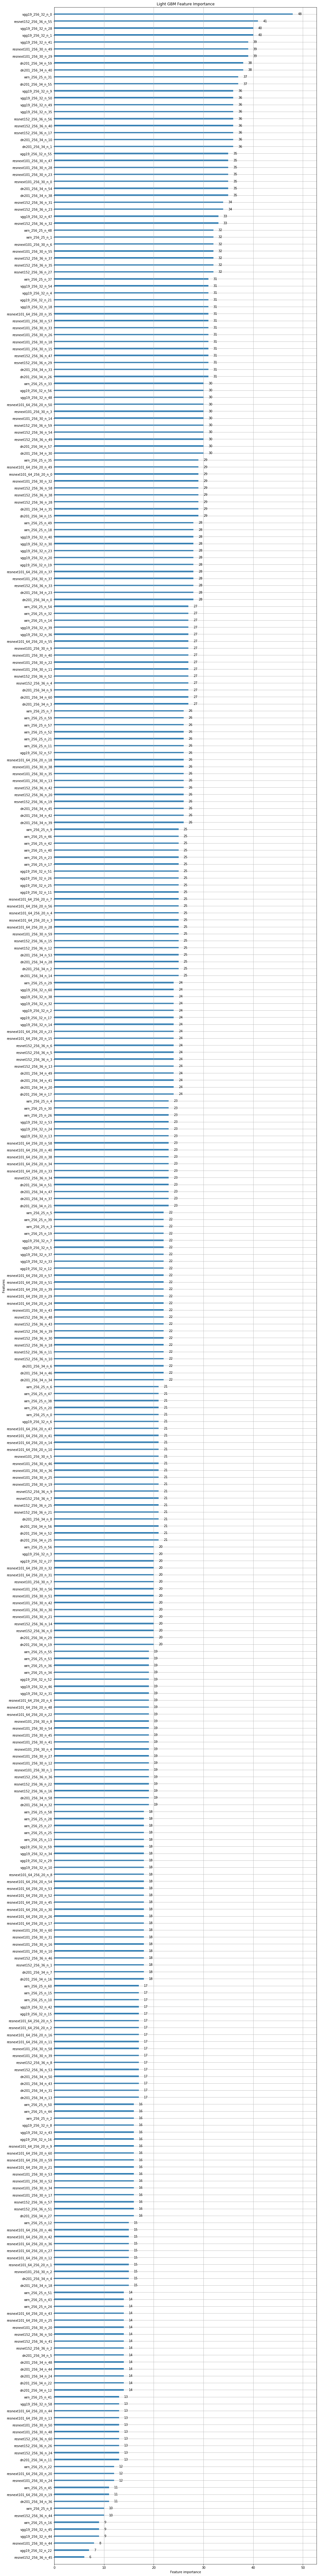

In [74]:
fig, ax = plt.subplots(figsize=(15, 150))
lgb.plot_importance(model, max_num_features=len(cols), ax=ax)
plt.title("Light GBM Feature Importance")